In [28]:
import pandas as pd
import numpy as np
import json
import os
import sys
from pathlib import Path

sys.path.append("..")
from common.constants import DATAFOLDER, COLUMNS
# from preprocess.src.preprocess import main
parent_dir = Path(os.path.abspath(""))
print(parent_dir.parent)
sys.path.append(parent_dir.parent)
sys.path.append(os.path.join(parent_dir.parent, "preprocess"))
from preprocess.src.feature_aggregation import agg_feature
from preprocess.src.features import sma, std
from preprocess.src.label_features import position_label

coin_name = "BTCUSDT"
data_file_path = os.path.join(
    DATAFOLDER.cleaned_data_root_path,
    coin_name,
    f"{coin_name}.parquet.gzip",
)
df = pd.read_parquet(data_file_path, engine="pyarrow")
df.head()

/Users/akiranoda/projects/crypto_model


,Open,High,Low,Close,Volume,CloseTime,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,Ignore
OpenTime,,,,,,,,,,,
1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,1502943299999,9333.620962,9,0.489061,2089.104962,7958.417415
1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,1502944199999,38891.133046,40,3.447113,14703.934995,7922.579933
1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,1502945099999,94080.917568,58,20.421317,87620.977876,7912.494217
1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,1502945999999,60060.466816,64,10.803012,46538.460109,7887.635513
1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,1502946899999,22006.533111,44,3.496635,15093.783057,7865.654419


In [29]:
feature_columns = []
df["sma5"] = sma(df, 5)
df["sma25"] = sma(df, 25)
df["sma50"] = sma(df, 50)
df["sma100"] = sma(df, 100)
feature_columns += [f"sma{i}" for i in [5, 25, 50, 100]]

df["std10"] = std(df, 10)
df["std25"] = std(df, 25)
df["std50"] = std(df, 50)
feature_columns += [f"std{i}" for i in [10, 25, 50]]

df["sma5_20_deviation_rate"] = 100 * (1 - sma(df, 20)) / sma(df, 5)
df["sma10_30_deviation_rate"] = 100 * (1 - sma(df, 30)) / sma(df, 10)
df["sma25_50_deviation_rate"] = 100 * (1 - sma(df, 50)) / sma(df, 25)
feature_columns += [f"sma{i}_{j}_deviation_rate" for i, j in zip([5, 10, 25], [20, 30, 50])]

# labels
df["y_buy"], df["buy_cost"], df["y_sell"], df["sell_cost"], df["buy_executed"], df["sell_executed"], df["buy_fet"], df["sell_fet"] = position_label(
    df, pips=1.0, fee_percent=0, horizon_barrier=1, executionType="check"
)

feature_columns += ["y_buy", "buy_cost", "y_sell", "sell_cost", "buy_executed", "sell_executed", "buy_fet", "sell_fet"]
df = df.dropna()
df = df[feature_columns]

In [30]:
df.head(30)

,sma5,sma25,sma50,sma100,std10,std25,std50,sma5_20_deviation_rate,sma10_30_deviation_rate,sma25_50_deviation_rate,y_buy,buy_cost,y_sell,sell_cost,buy_executed,sell_executed,buy_fet,sell_fet
OpenTime,,,,,,,,,,,,,,,,,,
1502986500,1.012645,1.030127,1.019030,1.019030,70.595967,49.377823,67.435895,-2.836360,-2.821722,-1.847305,0.000000,0.000000,-0.003944,-0.005361,0.0,1.0,3.0,1.0
1502987400,1.003607,1.025859,1.016268,1.015712,76.712424,55.790479,66.219469,-2.370147,-2.502980,-1.585840,0.000000,0.000000,-0.001594,-0.005348,0.0,1.0,2.0,1.0
1502988300,0.998520,1.022095,1.013525,1.012421,73.140692,57.555440,63.980504,-1.977618,-2.196999,-1.323298,-0.003134,-0.005512,0.000000,0.000000,1.0,0.0,1.0,11.0
1502989200,0.994865,1.017780,1.010475,1.009058,66.162182,59.233618,63.375927,-1.545434,-1.818230,-1.029226,-0.000162,-0.005528,0.000000,0.000000,1.0,0.0,1.0,10.0
1502990100,0.999093,1.019488,1.013573,1.011837,56.504464,60.232761,62.823324,-1.742373,-2.033231,-1.331354,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,9.0
1502991000,0.997777,1.014910,1.010572,1.008516,43.721483,60.515039,62.271632,-1.312848,-1.677504,-1.041662,0.003128,-0.005776,0.000000,0.000000,1.0,0.0,1.0,8.0
1502991900,1.011171,1.027371,1.024517,1.022205,33.846072,63.315148,63.097482,-2.551660,-2.945779,-2.386402,0.012756,-0.006295,0.000000,0.000000,1.0,0.0,1.0,7.0
1502992800,1.014415,1.032733,1.031180,1.028505,27.347513,67.131471,63.385368,-3.015910,-3.495956,-3.019186,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,6.0
1502993700,1.003922,1.023158,1.022927,1.020050,25.948062,69.514145,64.135469,-2.061756,-2.584514,-2.240838,0.013600,-0.006764,0.000000,0.000000,1.0,0.0,1.0,5.0


In [31]:
df.describe()

,sma5,sma25,sma50,sma100,std10,std25,std50,sma5_20_deviation_rate,sma10_30_deviation_rate,sma25_50_deviation_rate,y_buy,buy_cost,y_sell,sell_cost,buy_executed,sell_executed,buy_fet,sell_fet
count,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000
mean,1.000072,1.000010,0.999922,0.999758,37.649410,57.927153,81.574979,0.000187,0.007733,0.025656,0.000229,-0.001103,0.000124,-0.001061,0.385500,0.373353,2.694449,2.966628
std,0.004250,0.012033,0.017111,0.024963,51.684107,73.200835,95.049311,1.064530,1.313805,1.692431,0.004836,0.002038,0.004364,0.001995,0.486715,0.483697,2.190150,5.764174
min,0.899872,0.847767,0.852019,0.799223,0.000000,0.000000,0.000000,-23.138135,-28.518556,-31.004152,-0.125868,-0.039319,-0.230941,-0.043017,0.000000,0.000000,1.000000,1.000000
25%,0.998705,0.996075,0.993778,0.989843,11.474933,17.549101,25.580345,-0.295599,-0.369913,-0.497927,0.000000,-0.001700,0.000000,-0.001638,0.000000,0.000000,1.000000,1.000000
50%,0.999976,0.999708,0.999459,0.999128,20.747515,33.193479,49.774772,0.022717,0.034589,0.054137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,1.001278,1.003324,1.004994,1.007915,42.088965,67.885365,98.747841,0.342784,0.441062,0.624424,0.000039,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,4.000000
max,1.110797,1.286528,1.397649,1.585701,826.050481,904.861222,893.224660,15.020434,17.043694,17.064760,0.102502,0.000000,0.110563,0.000000,1.000000,1.000000,24.000000,216.000000


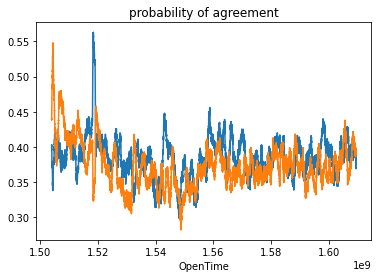

In [32]:
import matplotlib.pyplot as plt

# probability of make
df["buy_executed"].rolling(1000).mean().plot(label="buy")
df["sell_executed"].rolling(1000).mean().plot(label="sell")
plt.title("probability of agreement")
plt.show()
plt.close()

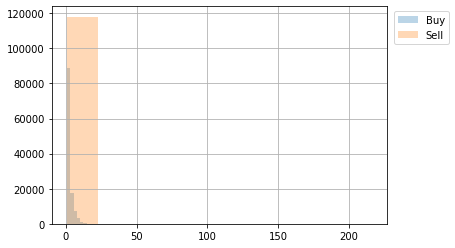

In [33]:
df['buy_fet'].hist(alpha=0.3, label='Buy')
df['sell_fet'].hist(alpha=0.3, label='Sell')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

False    88506
True     29795
Name: y_buy, dtype: int64
False    90142
True     28159
Name: y_sell, dtype: int64


<AxesSubplot:xlabel='OpenTime'>

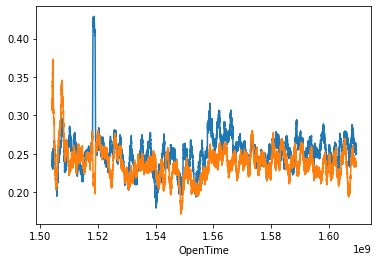

In [34]:
y_buy_positive = df["y_buy"] > 0
y_sell_positive = df["y_sell"] > 0

print(y_buy_positive.value_counts())
print(y_sell_positive.value_counts())
y_buy_positive.rolling(1000).mean().plot(label="buy_executed")
y_sell_positive.rolling(1000).mean().plot(label="sell_executed")
# plt.legend()
# plt.show()
# plt.close()

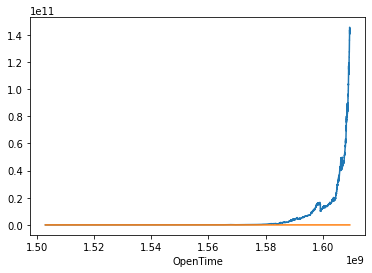

In [35]:
# cumulative return
buy_cum_return = (df["y_buy"] + 1).cumprod().plot(label="buy")
sell_cum_return = (df["y_sell"] + 1).cumprod().plot(label="sell")

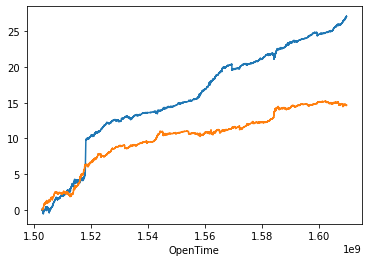

In [36]:
# cumulative return
buy_cum_return = df["y_buy"].cumsum().plot(label="buy")
sell_cum_return = df["y_sell"].cumsum().plot(label="sell")

In [37]:
buy_pos_return_average = df.loc[df["y_buy"] > 0]["y_buy"].mean()
buy_neg_return_average = df.loc[df["y_buy"] < 0]["y_buy"].mean()
print("+Return:", buy_pos_return_average, "-Return:", buy_neg_return_average)

+Return: 0.00376265213548511 -Return: -0.005383304387322382
